## Replicates - Comparisons

#### Batch 8 

I have a lot of replicate samples in my populations - true replicates, 300 v 500ng replicates, and reruns to see if I can replace low quality / low read depth / potentially contaminated samples. 

I need to (1) look at error rate between these replicates, and (2) decide which of the two samples I'll be using for my popgen analyses. 

For most of this I worked in excel; some graphs produced through R. 

<br>
#### 9/29/2017

### Replicates:

In [1]:
!cat ../analyses/batch_8_replicates.txt














































GEO020414_25	GEO020414_25_300

<br>
### Create Matrix file with only replicate samples

Loci are column headers, samples are in rows.

In [2]:
infile = open("../analyses/batch_8_replicates.txt", "r")
replicates_list = []
for line in infile:
    linelist = line.strip().split()
    for item in linelist:
        replicates_list.append(item)
infile.close()

In [3]:
# open original genepop, create new genepops
infile = open("../stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_filteredC_genepop.txt", "r")
repsfile = open("../stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_filteredC_reps.txt", "w")


pop_count = 0

title = infile.readline()
repsfile.write(title)

#save the title line of the genepop, all of the loci, and the first incidence of "Pop" to an object.
#then write that as the heading for all new genepop files.
heading = ""
for line in infile:
    if not line.startswith("Pop"):
        heading += line
    else:
        heading += line
        break

loci_list = heading.split()
repsfile.write("\t".join(loci_list) + "\n")

#separate individuals into the appropriate genepop file using the sample site abbrevs. in sample name
samples_added = []
for line in infile:
    sample = line.strip().split("\t")[0].strip(",")
    if sample in replicates_list:
        repsfile.write(line)
        samples_added.append(sample)
        
infile.close()
repsfile.close()

missing = len([i for i in replicates_list if i not in samples_added])
if missing > 0:
    print "Crap! ", missing, " samples not copied over"
else:
    print "All samples successfully copied into new genepop."

Crap!  18  samples not copied over


*these are probably samples that I have already filtered out*

<br>
<br>
### Compare Heterozygosity and Missing Genotypes between replicates

I did this in excel. See [this spreadsheet](). 

#### CHOOSING WHICH REPLICATES TO RETAIN: DECISION PROCESS

Used for all replicates EXCEPT 500v300ng replicates, where I used only the 300ng. 

<br>
*I don't know why this is sideways!*

![img-retain-samples-decision-tree](https://github.com/mfisher5/PCod-Korea-repo/blob/master/nb_pictures/reps_flowchart.jpg?raw=true)

<br>
<br>
**Missing Data & Heterozygosity**

Per the plot found in the ML Relate analyses for this batch, lower read depth usually led to lower heterozygosity. I noticed this in the replicates, when I re-ran samples in my fifth lane of sequencing because they had very low read depth in prior lanes. In all but one case, when the replicate had a higher read depth than the original, the replicate also had higher heterozygosity. see chart below:

![img-ho-missing-replicates]()


<br>
<br>

### Comparing genotypes between replicates

In [12]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/notebooks'

In [9]:
cd ../analyses

/mnt/hgfs/PCod-Korea-repo/analyses


In [13]:
# sort replicates by what TYPE of replicate they are
infile = open("rep_contam_filtering/batch_8_verif/batch_8_replicates_verif.txt", "r")

true_rep = [] #true replicate
redo = [] #redo because of low read depth OR high heterozygosity
ng300 = [] #rerun a 500ng sample as a 300ng sample

for line in infile:
    sample = line.strip().split()[0]
    replicate = line.strip().split()[1]
    if "_2" in replicate:
        redo.append(sample)
    elif "_300" in replicate:
        ng300.append(sample)
    elif "_rep" in replicate:
        true_rep.append(sample)
    else:
        true_rep.append(sample)
        
infile.close()

In [15]:
## NOTE THAT THIS CODE ONLY WORKS IF YOU HAVE THE REPLICATES PAIRED IN YOUR GENEPOP INPUT FILE ##
infile = open("../stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_filteredC_reps.txt", "r")
infile.readline() # header
loci_list = infile.readline()

true_rep_dict = {} # sample as key, values are: p_genotyped 1, p_genotyped 2, p_different w/ missing, p_different w/o missing
redo_dict = {} # sample as key, values are: p_genotyped 1, p_genotyped 2, p_different w/ missing, p_different w/o missing
ng300_dict = {} # sample as key, values are: p_genotyped 1, p_genotyped 2, p_different w/ missing, p_different w/o missing


line = infile.readline()
while line:
    linelist_r1 = line.strip().split()
    line = infile.readline()
    linelist_r2 = line.strip().split()
    sample1 = linelist_r1[0].strip(",")
    sample2 = linelist_r2[0].strip(",")
    genotypes1 = linelist_r1[1:]
    genotypes2 = linelist_r2[1:]
    n_geno_both = 0.0000000000000001
    for i in range(0,len(genotypes1)):
        if genotypes1[i] != "0000" and genotypes2[i] != "0000":
            n_geno_both += 1
    p_genotyped1 = float(len([i for i in genotypes1 if i != "0000"])) / float(len(genotypes1))
    p_genotyped2 = float(len([i for i in genotypes2 if i != "0000"])) / float(len(genotypes2))
    p_both_genotyped = float(n_geno_both) / float(len(genotypes1))
    n_diff = 0
    n_diff_wmissing = 0
    for i in range(1,len(linelist_r1)):
        if linelist_r1[i] != linelist_r2[i]:
            n_diff_wmissing += 1
            if linelist_r1[i] != "0000" and linelist_r2[i] != "0000":
                n_diff += 1
    p_diff = float(n_diff) / float(n_geno_both)
    p_diff_wmissing = float(n_diff_wmissing) / float(len(linelist_r1[1:]))
    if sample1 in true_rep or sample2 in true_rep:
        true_rep_dict[sample1] = [p_genotyped1, p_genotyped2, p_both_genotyped, p_diff_wmissing, p_diff]
    elif sample1 in redo or sample2 in redo:
        redo_dict[sample1] = [p_genotyped1, p_genotyped2, p_both_genotyped, p_diff_wmissing, p_diff]
    elif sample1 in ng300 or sample2 in ng300:
        ng300_dict[sample1] = [p_genotyped1, p_genotyped2, p_both_genotyped, p_diff_wmissing, p_diff]
    else: 
        print "Cannot locate sample " + sample1
    line = infile.readline()
infile.close()

In [16]:
print true_rep_dict.keys()

['JUK07_16.1', 'JB021108_05', 'JB121807_08', 'GE011215_11', 'JB021108_35', 'PO010715_07', 'JUK07_02.1', 'JB021108_37.1', 'JB121807_03.1', 'JUK07_09.1', 'JB021108_36.1', 'JB021108_46.1']


In [17]:
print true_rep_dict['JUK07_16.1']

[0.9815644383184011, 0.981736733287388, 0.9812198483804273, 0.04376292212267402, 0.0437225636523266]


*this checks out in excel!*

** Graph the proportion of genotypes different between replicates, color-coded based on the type of replicate**

In [18]:
all_p_diff = []
true_reps_p_diff = []
all_p_genotyped = []
colors = []

for i in true_rep_dict.keys():
    all_p_diff.append(true_rep_dict[i][4])
    true_reps_p_diff.append(true_rep_dict[i][4])
    all_p_genotyped.append(true_rep_dict[i][2])
    colors.append("darkcyan")
for i in redo_dict.keys():
    all_p_diff.append(redo_dict[i][4])
    all_p_genotyped.append(redo_dict[i][2])
    colors.append("magenta")
for i in ng300_dict.keys():
    all_p_diff.append(ng300_dict[i][4])
    all_p_genotyped.append(ng300_dict[i][2])
    colors.append("gray")

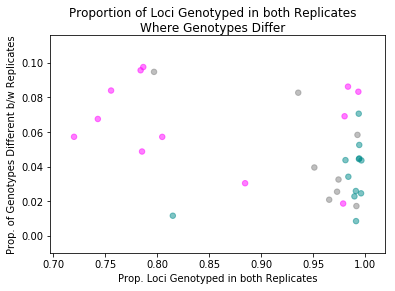

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(all_p_genotyped, all_p_diff, color = colors, s = 30, alpha = 0.5)
plt.suptitle("Proportion of Loci Genotyped in both Replicates\nWhere Genotypes Differ")
plt.xlabel("Prop. Loci Genotyped in both Replicates")
plt.ylabel("Prop. of Genotypes Different b/w Replicates")
plt.show()

In [20]:
plt.close()

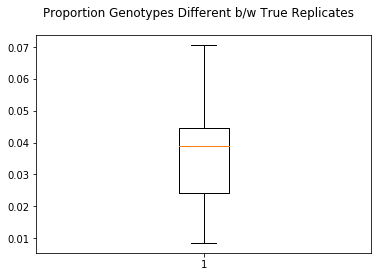

In [21]:
plt.boxplot(true_reps_p_diff)
plt.suptitle("Proportion Genotypes Different b/w True Replicates")
plt.show()

In [22]:
plt.close()

<br>
<br>

### final filtered genepop file

In [7]:
pwd

u'/mnt/hgfs/PCod-Korea-repo/notebooks'

In [8]:
cd ../

/mnt/hgfs/PCod-Korea-repo


In [9]:
infile = open("stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_genepop.txt", "r")
samplefile = open("scripts/Batch_8_verif_Samples_Reps_Contam_removed.txt", "r")
outfile = open("stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_filteredCR_genepop.txt", "w")

## get list of samples to remove
count = 0
samples_to_remove = []
for line in samplefile:
    if not line.startswith("#"):
        samples_to_remove.append(line.strip())
        count += 1
samplefile.close()
print "Removing ", count, " samples from file."

## remove those samples from genepop and write to new file
keep = 0
line = infile.readline()
while not line.startswith("Pop"):
    outfile.write(line)
    line = infile.readline()
outfile.write(line)
for line in infile:
    if line.startswith("Pop"):
        outfile.write(line)
    else:
        sample = line.strip().split()[0].strip(",")
        if sample not in samples_to_remove:
            outfile.write(line)
            keep += 1
print "Wrote ", keep, " samples to new file."
infile.close()
outfile.close()

Removing  61  samples from file.
Wrote  237  samples to new file.


In [10]:
print len(samples_to_remove)

61


In [11]:
inmap = open("scripts/PopMap_L1-5_mdFilter_b8_verif.txt", "r")
outmap = open("scripts/PopMap_Final.txt", "w")
count = 0
for line in inmap:
    sample = line.strip().split()[0]
    if sample not in samples_to_remove:
        outmap.write(line)
        count += 1
inmap.close()
outmap.close()
print "There are ", count, " samples in the final population map file."

There are  237  samples in the final population map file.


##  Final Genepop File:
### stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_filteredCR_genepop.txt

<br>

## Final Population Map File:
### scripts/PopMap_Final.txt


<br>
<br>

*Double checked that all replicates were removed and all good samples were retained in excel.*




